# Used to distill a flow Velocities from drone Video data

In [1]:
import matplotlib 
matplotlib.use("Agg") 
import matplotlib.pyplot as plt
import sys
import argparse
import cv2

from openpiv import tools, process, validation, filters, scaling 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import imageio

import pandas as pd
import xarray as xr

import openpiv.tools
import openpiv.process 
import openpiv.scaling 
import openpiv.validation 
import openpiv.filters
import glob



import pandas as pd
import xarray as xr
import fsspec

import urllib
import urllib.request
from urllib.request import urlopen

import IPython ## 
from IPython import display
display.set_matplotlib_formats('retina')
from IPython.display import YouTubeVideo
import glob
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
%matplotlib inline  

!pip install fsspec==0.8.4

### Define Function to extract Velocity Fields from Video Data

In [6]:
def Vid2PIV(pathIn, pathOut, AGL, FOV):
    
    """ Vid2PIV is a function used to convert still hovering drone footage to scaled velocity fields which can be analyzed in xarray. 
    It is an implementation of particle image velocimetry based on OpenPIV.
    
    INPUTS: 
   
    pathIn: Local path to video (.mov or .mp4 file format)
    pathOut: Name you would like to save your veloci
    AGL: Above ground level (Altitude of drone) in meters
    FOV: Field of View of sensor in degrees
    
    OUTPUTS: A saved xarray dataset in .nc file format
    
    """
    
    
    count = 0
    vidcap = cv2.VideoCapture(pathIn)
    success, frame_a = vidcap.read()
    

    
    tf =  int(np.floor(vidcap.get(cv2.CAP_PROP_FRAME_COUNT)/ vidcap.get(cv2.CAP_PROP_FPS))) #to get number of seconds in video final time
    print(tf)
    x, y = process.get_coordinates( image_size=frame_a.shape, window_size=64, overlap=32 )
    
    
    dfi = xr.Dataset(
        data_vars={'u': (('x', 'y', 'time'), np.zeros((len(x[0,:]),len(y[:,0]),tf-1))),
                   'v': (('x', 'y', 'time'), np.zeros((len(x[0,:]),len(y[:,0]),tf-1))),
                   's': (('x', 'y', 'time'), np.zeros((len(x[0,:]),len(y[:,0]),tf-1)))},
        coords={'x': x[0,:],'y': y[:,0],'time':np.arange(tf-1)})
    
    
    frame_a = frame_a[:,:,2]*0.2989 + frame_a[:,:,1]*0.5870 + 0.1140*frame_a[:,:,0] #convert to greyscle
    frame_a = (frame_a).astype(np.int32)
    
    
    #Calulate GSD for video
    AGL = AGL #meters  
    FOV = np.deg2rad(FOV) #degrees
    Width  = vidcap.get(cv2.CAP_PROP_FRAME_WIDTH)   # float `width` in pixels
    Height = vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float `height` in pixels
    Aspect = Height/Width    # CONFIRM THIS IS CORRECT
    D =   2 * AGL *np.tan(FOV/2) #diagnol of image
    A = (D) / np.sqrt(1 + Aspect**2)
    B = Aspect * D / np.sqrt(1 + Aspect**2)
    print('Image Footprint:',A, 'm x', B, 'm y')
    GSDx = A/ Width
    GSDy = B/ Height
    

    
    
    for count in np.arange(tf-2):
        
        vidcap.set(cv2.CAP_PROP_POS_MSEC,((count+1)*1000))    # added this line (1000 is 1 second, 100 is .1 sec) 
        success,frame_b = vidcap.read()
        print ('Read a new frame', "%03d" % (count+1), success)  #take it out
      
      #PIV
               
        frame_b = frame_b[:,:,2]*0.2989 + frame_b[:,:,1]*0.5870 + 0.1140*frame_b[:,:,0]
        frame_b = (frame_b).astype(np.int32)
       

        u, v, sig2noise = process.extended_search_area_piv( frame_a, frame_b, \
            window_size=64, overlap=32, dt=1, search_area_size=128, sig2noise_method='peak2peak' )
        #x, y = process.get_coordinates( image_size=frame_a.shape, window_size=64, overlap=32 )
        u, v, mask = validation.sig2noise_val( u, v, sig2noise, threshold = 1.2 )
        u, v, mask = validation.global_val( u, v, (-1000, 2000), (-1000, 1000) )
        u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
        #x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 1)
    
        
        dfi.u[:,:,count] = np.transpose(u)
        dfi.v[:,:,count] = np.transpose(v)
    
    
    
    # additional processing
    #Sensor and Drone Measurments 
        dfi.u[:,:,count] = dfi.u[:,:,count] *GSDx 
        dfi.v[:,:,count] = dfi.v[:,:,count]*-1 * GSDy # the negative is to make the downstream velocity positive
        dfi.s[:,:,count] = np.sqrt(dfi.u[:,:,count]**2+dfi.v[:,:,count]**2) 
        

        
        frame_a = frame_b
    
    #Spatial Calculation (can possibly take this out of the loop?)
    dfi['x'] = dfi.x*GSDx 
    dfi['y']= dfi.y*GSDy 
    
    dfi.to_netcdf(pathOut)
    
    return(dfi)

## Run velocimetry on video
### Define path of video, saved file name and flight parameters

In [ ]:
idd = 'NLhjNzQHphQ'
Saved = 'Plume_V'
pathIn = '/Users/Jasper/Volc_Research/Workflow_OPENPIV/Local_Drive_Workflow/Plume_Eruption.mov'
AGL = 304.8   #
FOV =78.8

vid = Vid2PIV(pathin, Saved, AGL, FOV)

### Inspect How it looks

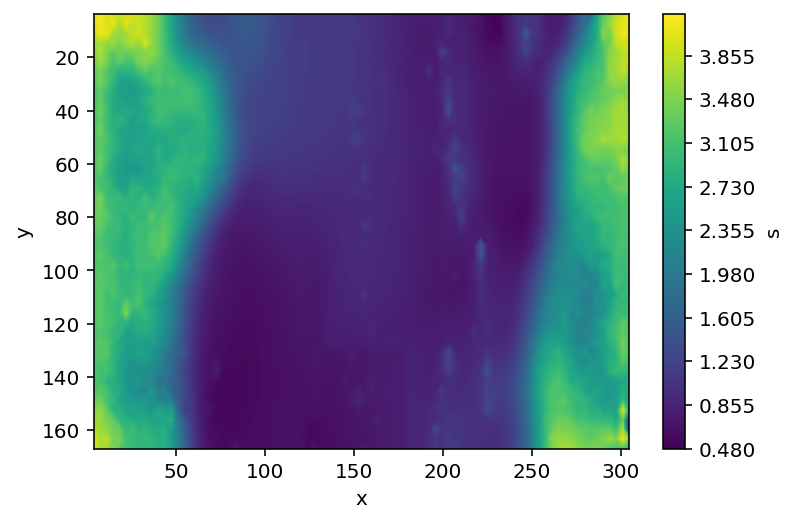

In [52]:
df0.s.mean(dim='time').transpose().plot.contourf( levels=300,yincrease=False)

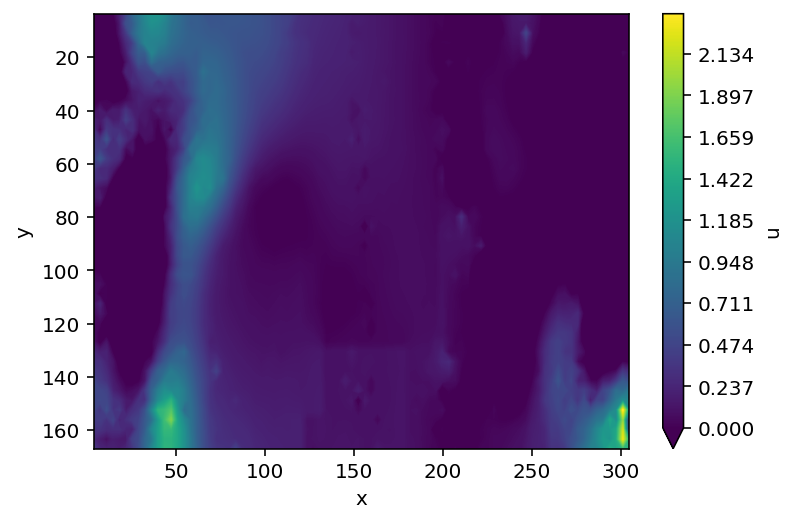

In [101]:
df0.u.mean(dim='time').transpose().plot.contourf( levels=300, vmin=0,  yincrease=False)

In [7]:
#Compare
dfx = xr.open_dataset('DJI_0002_20180726_1308-Vpt4postTypeA_Trim.nc')
dfx

<xarray.Dataset>
Dimensions:  (time: 119, x: 119, y: 66)
Coordinates:
  * x        (x) float64 3.629 7.258 10.89 14.52 ... 420.9 424.6 428.2 431.8
  * y        (y) float64 3.629 7.258 10.89 14.52 ... 228.6 232.2 235.9 239.5
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 111 112 113 114 115 116 117 118
Data variables:
    u        (x, y, time) float64 ...
    v        (x, y, time) float64 ...
    s        (x, y) float64 ...

In [8]:
dfx.where(dfx.s>.15).mean().values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables:
    u        float64 0.1554
    v        float64 1.304
    s        float64 1.41>

## Subtract out drone motion from velocity fields

#### Subtract out v velocity of still region from image

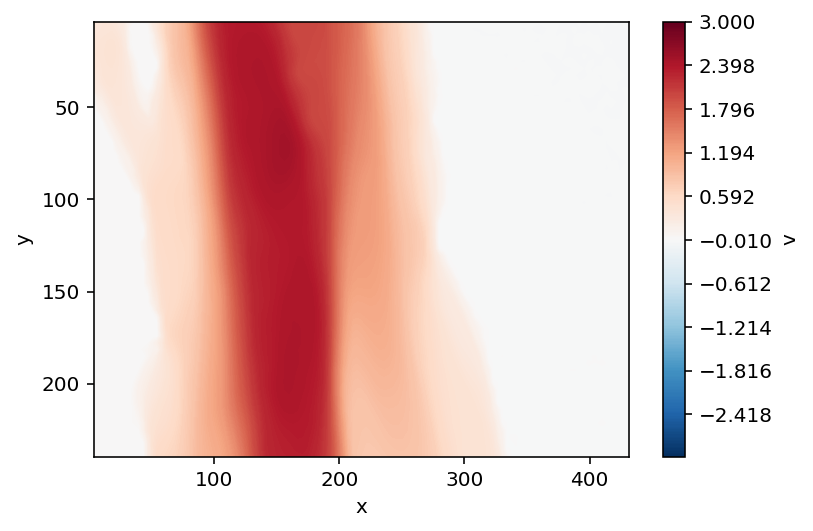

In [9]:
#Visually inspect where still regions should be
dfx.v.mean(dim='time').transpose().plot.contourf( levels=300, vmax=3, yincrease=False)

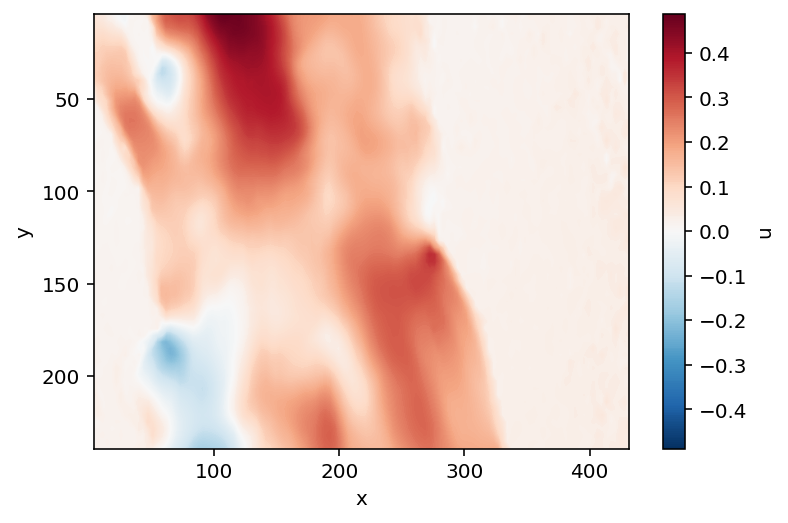

In [10]:
#Visually inspect where still regions should be
dfx.u.mean(dim='time').transpose().plot.contourf( levels=300, yincrease=False)

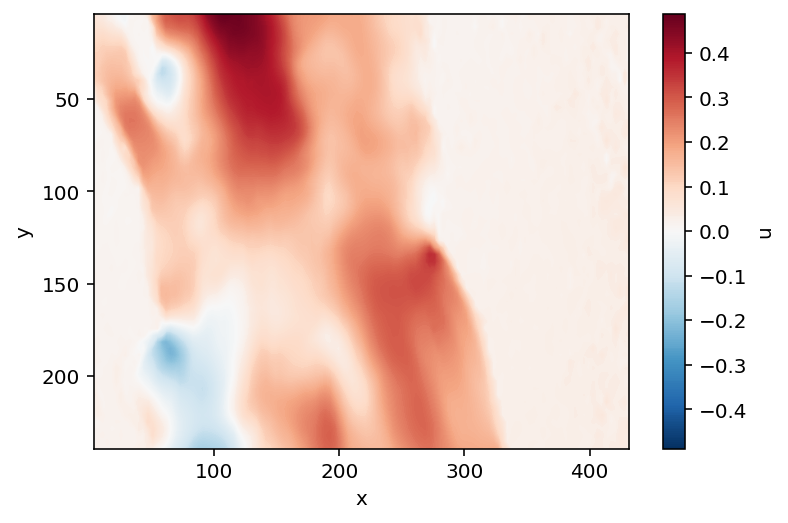

In [11]:
#Visually inspect where still regions should be
dfx.u.mean(dim='time').transpose().plot.contourf( levels=300, yincrease=False)

In [12]:
for i in range(len(dfx.time)):
    #Correct for v drone motion velocity 
    Av = dfx.sel(time= i, x=slice(350,432), y=slice(0, 237)).v.mean(dim= ('x', 'y'))
    Bv = dfx.sel(time= i, x=slice(0,25), y=slice(100, 237)).v.mean(dim= ('x', 'y'))
    Cv = (Av+Bv)/ 2
    dfx.v[i] = dfx.v[i] - Cv
    
    #correct for u drone motion velocity
    Au = dfx.sel(time= i, x=slice(350,432), y=slice(0, 237)).u.mean(dim= ('x', 'y'))
    Bu = dfx.sel( time= i, x=slice(0,25), y=slice(100, 237)).u.mean(dim= ('x', 'y'))
    Cu = (Au+Bu)/ 2
    dfx.u[i] = dfx.u[i] - Cu

    #correct for s drone motion velocity
    As = dfx.sel(time= i, x=slice(350,432), y=slice(0, 237)).s.mean(dim= ('x', 'y'))
    Bs = dfx.sel( time= i, x=slice(0,25), y=slice(100, 237)).s.mean(dim= ('x', 'y'))
    Cs = (As+Bs)/ 2
    dfx.s[i] = dfx.s[i] - Cs

In [13]:
dfx.to_netcdf('Site4_Drone_Subtract')

### Combine all Flights into one Dataset with new dimension (Flight)

In [10]:
Flights = [df07, df08, df09, df10]
dfx = xr.concat(Flights, dim = 'Flight')
dfx =dfx.sortby('Flight', ascending=True)
dfx = dfx.assign_coords(Flight =['F07','F08','F09', 'F10'])
dfx['time'] =np.arange(0,120)
dfx

<xarray.Dataset>
Dimensions:  (Flight: 4, time: 120, x: 119, y: 66)
Coordinates:
  * x        (x) float64 32.0 64.0 96.0 128.0 ... 3.744e+03 3.776e+03 3.808e+03
  * y        (y) float64 32.0 64.0 96.0 128.0 ... 2.048e+03 2.08e+03 2.112e+03
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 112 113 114 115 116 117 118 119
  * Flight   (Flight) <U3 'F07' 'F08' 'F09' 'F10'
Data variables:
    u        (Flight, time, x, y) float64 0.3826 0.4679 ... -0.5201 -0.5707
    v        (Flight, time, x, y) float64 -2.979 -3.021 ... 0.1432 -0.1152
    mask     (Flight, time, x, y) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [148]:
df0.where(df0.v<df0.v.quantile([.9999,1.00]))
#df0.u = df0.where(df0.u<df0.u.quantile([.9999,1.00]))

<xarray.Dataset>
Dimensions:   (quantile: 2, time: 1, x: 119, y: 66)
Coordinates:
  * x         (x) float64 3.629 7.258 10.89 14.52 ... 420.9 424.6 428.2 431.8
  * y         (y) float64 3.629 7.258 10.89 14.52 ... 228.6 232.2 235.9 239.5
  * time      (time) int64 0
  * quantile  (quantile) float64 0.9999 1.0
Data variables:
    u         (x, y, time, quantile) float64 0.4807 0.4807 ... 0.02616 0.02616
    v         (x, y, time, quantile) float64 -0.3472 -0.3472 ... 0.3194 0.3194
    s         (x, y, time, quantile) float64 0.593 0.593 ... 0.3204 0.3204

## Save the Xarray with all the velocity fields

In [58]:
dfx.to_netcdf('0726_Site4_Velocity_Fields.nc') # Saves on your local disk 